SPACY

In [1]:
import pandas as pd
import numpy as np
import spacy

In [2]:
df = pd.read_csv('twitter_training.csv')

In [3]:
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
df.drop(columns=['2401'], inplace=True)

In [5]:
df.rename(columns={
'Borderlands':'Game_Name',
'Positive':'Sentiment',
'im getting on borderlands and i will murder you all ,':'tweet'
}, inplace=True)

In [6]:
df.head()

,Game_Name,Sentiment,tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
df.isna().sum()

,0
Game_Name,0
Sentiment,0
tweet,686


In [10]:
df.dropna(inplace=True)
df.isna().sum()

,0
Game_Name,0
Sentiment,0
tweet,0


In [11]:
df_pos = df[df['Sentiment']=='Positive'].iloc[:2000]
df_neg = df[df['Sentiment']=='Negative'].iloc[:2000]
df_neu = df[df['Sentiment']=='Neutral'].iloc[:2000]
df_irr = df[df['Sentiment']=='Irrelevant'].iloc[:2000]
df2 = pd.concat([df_pos,df_neg,df_neu,df_irr], axis=0)
df2.Sentiment.value_counts()

,count
Sentiment,
Positive,2000
Negative,2000
Neutral,2000
Irrelevant,2000


In [12]:
df2.head(2)

,Game_Name,Sentiment,tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [13]:
game_mapping = {name:i for i,name in enumerate(df2['Game_Name'].unique())}
df2['Game_ID'] = df2['Game_Name'].map(game_mapping)
df2.drop(columns=['Game_Name'], inplace=True)
df2.head(2)

,Sentiment,tweet,Game_ID
0,Positive,I am coming to the borders and I will kill you...,0
1,Positive,im getting on borderlands and i will kill you ...,0


In [16]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 50.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [17]:
nlp = spacy.load("en_core_web_md")

def preprocess(text):
    doc = nlp(text)
    lemmaList = [word.lemma_ for word in doc]
    doc2 = nlp(" ".join(lemmaList))
    no_stop_w = [word.text for word in doc2 if not word.is_stop and not word.is_punct]
    return " ".join(no_stop_w)

df2['final'] = df2['tweet'].apply(preprocess)
df2.head(2)

,Sentiment,tweet,Game_ID,final
0,Positive,I am coming to the borders and I will kill you...,0,come border kill
1,Positive,im getting on borderlands and i will kill you ...,0,m borderland kill


In [18]:
df2.drop(columns=['tweet'], inplace=True)
df.head(2)

,Game_Name,Sentiment,tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [34]:
df2.head(2)

,Sentiment,Game_ID,final
0,Positive,0,come border kill
1,Positive,0,m borderland kill


In [35]:
df3=df2.copy()

In [19]:
def get_spacy_vector(text):
    return nlp(text).vector  # 300-dim vector

vectors = np.vstack(df2['final'].apply(get_spacy_vector).values)
embedding_df = pd.DataFrame(vectors)
embedding_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.814413,0.109663,-0.078903,-0.251469,-0.19761,-0.282759,-0.236343,0.058367,-0.066080,1.987767,...,-0.268797,-0.132890,-0.31899,0.015641,-0.130003,0.288057,-0.094228,-0.260173,-0.045000,0.270869
1,-0.868257,0.598797,0.252750,-0.099669,-0.12973,0.019740,-0.238909,0.185207,-0.108148,0.226760,...,0.104103,-0.359777,-0.26345,-0.165707,0.127143,0.054410,-0.036871,-0.064407,-0.398136,0.135822


In [24]:
X = pd.concat([embedding_df, df2['Game_ID'].reset_index(drop=True)], axis=1)
y = df2['Sentiment'].reset_index(drop=True)
X.columns = X.columns.astype(str)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [25]:
X_train.shape,X_test.shape

((6400, 301), (1600, 301))

In [26]:
X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Game_ID
1467,-0.853635,0.144460,-0.301555,-0.158459,-0.180061,0.074825,-0.464910,-0.031870,-0.155705,1.202610,...,-0.175307,-0.151350,-0.003315,-0.131010,0.074925,-0.288076,0.108760,0.025268,0.011549,1
5768,-0.619128,0.173717,-0.041579,0.014976,-0.012818,-0.119980,-0.028796,-0.128107,0.176146,1.412893,...,0.036044,-0.104796,-0.091588,-0.160478,0.130667,-0.044626,-0.026208,0.145298,0.129631,2


In [27]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42,n_estimators=200)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [28]:
y_test[:5]

,Sentiment
2215,Negative
2582,Negative
1662,Positive
3027,Negative
4343,Neutral


In [29]:
y_pred[:5]

array(['Negative', 'Irrelevant', 'Positive', 'Negative', 'Neutral'],
      dtype=object)

              precision    recall  f1-score   support

  Irrelevant       0.86      0.84      0.85       399
    Negative       0.81      0.79      0.80       379
     Neutral       0.85      0.87      0.86       397
    Positive       0.82      0.84      0.83       425

    accuracy                           0.84      1600
   macro avg       0.84      0.84      0.84      1600
weighted avg       0.84      0.84      0.84      1600



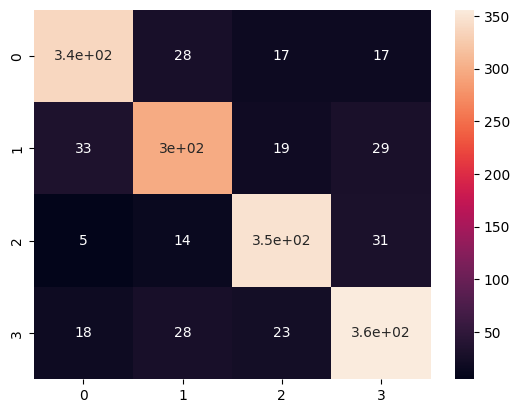

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))

import seaborn as sn
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred)
sn.heatmap(cm,annot=True)
plt.show()


FASTTEXT

In [32]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 68.5 MB/s eta 0:00:00
[==========================================--------] 84.1% 806.0/958.4MB downloaded

ContentTooShortError: <urlopen error retrieval incomplete: got only 845130474 out of 1005007125 bytes>

In [33]:
import gensim.downloader as api
ft = api.load('glove-wiki-gigaword-300')


[==================================================] 100.0% 376.1/376.1MB downloaded


In [37]:
df3.head()

,Sentiment,Game_ID,final
0,Positive,0,come border kill
1,Positive,0,m borderland kill
2,Positive,0,m come borderland murder
3,Positive,0,m borderland 2 murder
4,Positive,0,m borderland murder


In [38]:
def get_glove_vector(text):
    words = text.split()
    vecs = [ft[w] for w in words if w in ft]
    if len(vecs) == 0:
        return np.zeros(300)
    return np.mean(vecs, axis=0)

In [39]:
vectors_glove = np.vstack(df3['final'].apply(get_glove_vector).values)
embedding_df_glove = pd.DataFrame(vectors_glove)
embedding_df_glove.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.108018,0.317871,-0.168885,0.104138,-0.397803,0.044863,-0.030638,0.310308,0.201187,-1.434633,...,0.077561,-0.416077,0.055261,-0.052520,-0.019575,0.364042,0.111426,-0.139783,0.013323,0.501313
1,0.022175,0.547917,-0.033079,-0.079833,-0.382467,0.276607,0.365116,0.511063,0.125416,-0.477407,...,-0.069143,-0.127140,-0.014333,-0.088577,0.334346,-0.088857,0.138350,0.119522,-0.138770,0.396647


In [40]:
X_glove = pd.concat([embedding_df_glove, df3['Game_ID'].reset_index(drop=True)], axis=1)
y_glove = df3['Sentiment'].reset_index(drop=True)
X_glove.shape,y_glove.shape

((8000, 301), (8000,))

In [41]:
X_glove.columns = X_glove.columns.astype(str)

In [42]:
from sklearn.model_selection import train_test_split
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(
    X_glove, y_glove, test_size=0.2, random_state=42)

In [43]:
from sklearn.ensemble import RandomForestClassifier
model_glove = RandomForestClassifier(random_state=42, n_estimators=200)
model_glove.fit(X_train_glove, y_train_glove)

RandomForestClassifier(n_estimators=200, random_state=42)

In [44]:
y_pred_glove = model_glove.predict(X_test_glove)

In [45]:
y_test_glove[:5]

,Sentiment
2215,Negative
2582,Negative
1662,Positive
3027,Negative
4343,Neutral


In [46]:
y_pred_glove[:5]

array(['Negative', 'Negative', 'Positive', 'Negative', 'Neutral'],
      dtype=object)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_glove, y_pred_glove))

              precision    recall  f1-score   support

  Irrelevant       0.88      0.80      0.84       399
    Negative       0.82      0.82      0.82       379
     Neutral       0.82      0.84      0.83       397
    Positive       0.82      0.86      0.84       425

    accuracy                           0.83      1600
   macro avg       0.83      0.83      0.83      1600
weighted avg       0.83      0.83      0.83      1600



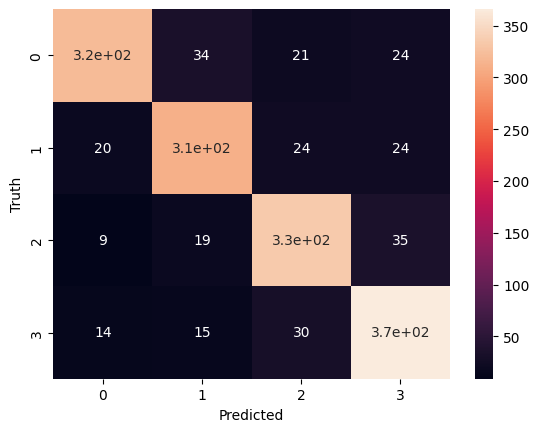

In [48]:
import seaborn as sn
import matplotlib.pyplot as plt
cm_glove = confusion_matrix(y_test_glove, y_pred_glove)
sn.heatmap(cm_glove, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()